In [3]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.nn.modules.loss import BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet18, vgg19, resnet50
from google.colab import drive, files
from collections import Counter
import seaborn as sns
from torchsummary import summary

In [4]:
# Mount drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
checkpoints_path = '/content/drive/MyDrive/Hackathon/model_checkpoints_resnet/'
data_root_path = '/content/drive/MyDrive/Hackathon/dataset/'
train_path = data_root_path + 'train/'
val_path = data_root_path + 'val/'
test_path = data_root_path + 'test/'
print(test_path)

/content/drive/MyDrive/Hackathon/dataset/test/


In [ ]:
def batch_mean_and_std(dataloader):

    count = 0
    fst_moment = torch.empty(3).to(device)
    snd_moment = torch.empty(3).to(device)

    for images, _ in tqdm(dataloader):
      images = images.to(device)
      b, c, h, w = images.shape
      nb_pixels = b * h * w
      sum_ = torch.sum(images, dim=[0, 2, 3])
      sum_of_squares = torch.sum(images ** 2, dim=[0, 2, 3])
      fst_moment = (count * fst_moment + sum_) / (count + nb_pixels)
      snd_moment = (count * snd_moment + sum_of_squares) / (count + nb_pixels)
      count += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
    return mean, std

In [ ]:
data_transform_without_normalisation = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
image_dataset_train = datasets.ImageFolder(root = train_path, transform=data_transform_without_normalisation)
dataloader_train = DataLoader(image_dataset_train,batch_size=20,shuffle = False, num_workers = 2)

In [ ]:
# DO NOT RUN this block unless you want to recalculate the mean and standard deviation of the training dataset
# train_mean, train_std = batch_mean_and_std(dataloader_train)
# print('Mean of training images = {}, Std of training images = {}'.format(train_mean, train_std))


We take random samples from the training dataset and normalize them using the Mean and Standard Deviation calculated above. We also normalize the random samples using the Mean and Standard Deviation of the ImageNet dataset. We visualize all of these below.

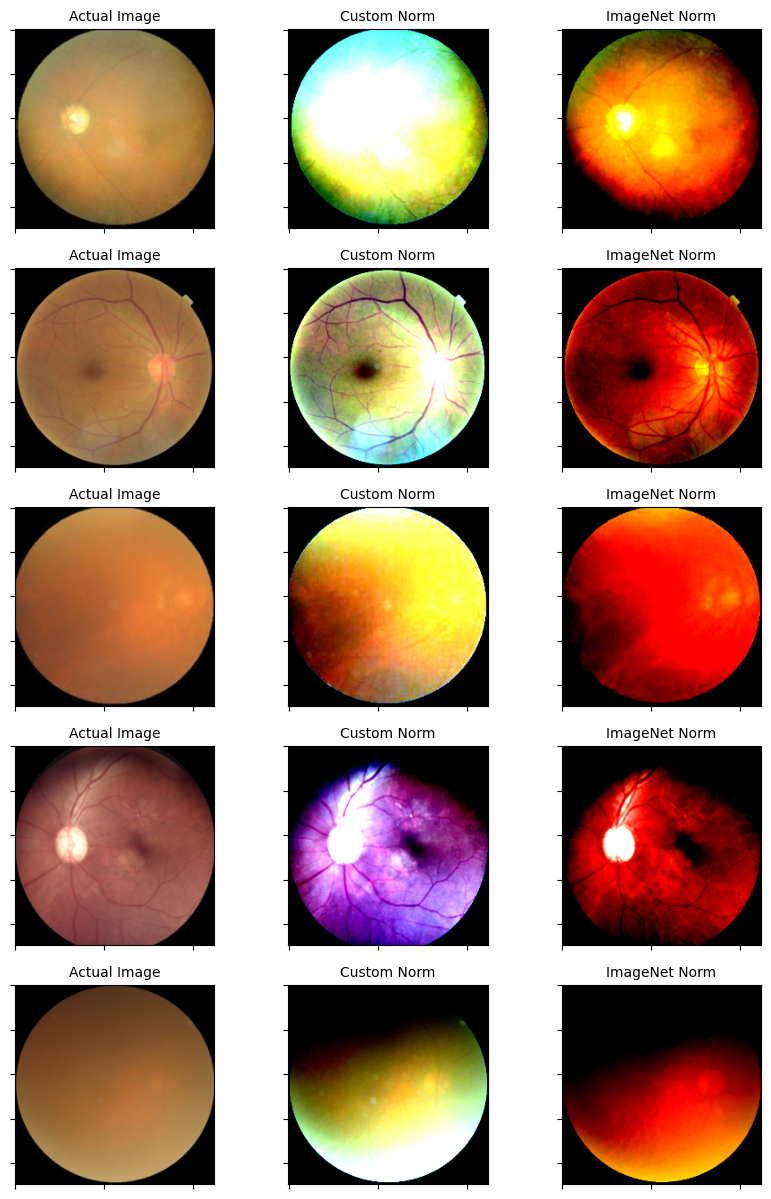

In [ ]:
# Display 5 random images from the training dataset
# Left: actual image, Middle: normalized image using derived mean and std, Right: normalized image using ImageNet mean and std
# We shall use the derive mean and std that has been calculated from the training dataset

train_mean, train_std = [0.4245, 0.2786, 0.1763], [0.2823, 0.2003, 0.1553]
normalize_transform_actual = transforms.Normalize(mean=train_mean, std=train_std)
normalize_transform_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def display_images(num_images=5):
  idx_list = torch.randint(0, len(image_dataset_train), (num_images,))
  f, axarr = plt.subplots(num_images, 3, figsize=(10, 3 * num_images))
  i = 0
  for idx in idx_list:
    sample_idx_orig = image_dataset_train[idx][0].permute(1, 2, 0).cpu()
    sample_idx_norm_actual = normalize_transform_actual(image_dataset_train[idx][0]).permute(1, 2, 0).cpu()
    sample_idx_norm_imagenet = normalize_transform_imagenet(image_dataset_train[idx][0]).permute(1, 2, 0).cpu()

    axarr[i, 0].imshow(sample_idx_orig)
    axarr[i, 0].set_title('Actual Image', fontsize=10)
    axarr[i, 0].grid(False)
    axarr[i, 0].xaxis.set_tick_params(labelbottom=False)
    axarr[i, 0].yaxis.set_tick_params(labelleft=False)

    axarr[i, 1].imshow(sample_idx_norm_actual)
    axarr[i, 1].set_title('Custom Norm', fontsize=10)
    axarr[i, 1].grid(False)
    axarr[i, 1].xaxis.set_tick_params(labelbottom=False)
    axarr[i, 1].yaxis.set_tick_params(labelleft=False)

    axarr[i, 2].imshow(sample_idx_norm_imagenet)
    axarr[i, 2].set_title('ImageNet Norm', fontsize=10)
    axarr[i, 2].grid(False)
    axarr[i, 2].xaxis.set_tick_params(labelbottom=False)
    axarr[i, 2].yaxis.set_tick_params(labelleft=False)

    i += 1

display_images()

In [ ]:
train_mean, train_std = [0.4245, 0.2786, 0.1763], [0.2823, 0.2003, 0.1553]
data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=train_mean, std=train_std)])


image_datasets = {'train': datasets.ImageFolder(root=train_path, transform=data_transforms),
                  'validation': datasets.ImageFolder(root=val_path, transform=data_transforms),
                  'test': datasets.ImageFolder(root=test_path, transform=data_transforms)}


dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=20, shuffle=True, num_workers=2),
               'validation': DataLoader(image_datasets['validation'], batch_size=20, shuffle=False, num_workers=2),
               'test': DataLoader(image_datasets['test'], batch_size=20, shuffle=False, num_workers=2)}

print('Labels = {}'.format(image_datasets['test'].class_to_idx))

print('Training dataset size = {}'.format(len(image_datasets['train'])))
print('Validation dataset size = {}'.format(len(image_datasets['validation'])))
print('Test dataset size = {}'.format(len(image_datasets['test'])))

Labels = {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}
Training dataset size = 3417
Validation dataset size = 400
Test dataset size = 400


The Resnet50 with pretrained parameters is used, Added fully-connected layers with a dropout of 0.5.

In [ ]:
def create_model(num_classes=4):
  model = resnet50(pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

    model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(128, num_classes)
    )

    model = model.to(device)
    return model

This is the method to save the model after every epoch during training. We also save other metrics like the training loss, training accuracy, validation loss and validation accuracy observed for a particular epoch in the checkpoint so that they can be later used for generating visualizations.

In [ ]:
def save_model(model, optimizer, epoch, train_loss, train_acc, val_loss, val_acc):
  colab_checkpoint_path = checkpoints_path + 'training_checkpoint_epoch_' + str(epoch) + '.pth'
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
            }, colab_checkpoint_path)
  print('{} checkpoint for epoch {} saved...'.format(colab_checkpoint_path, epoch))

This is the method which trains the model on the training data and then validates it on the validation dataset for the specified number of epochs. It invokes the save_model() method above to save the model checkpoint after every epoch.

In [ ]:
def train_model(model, loss_fn, optimizer,device, epoch_to_start,no_epochs = 5):
  epoch_train_loss_list, epoch_validation_loss_list = [], []
  epoch_train_acc_list, epoch_validation_acc_list = [], []
  for epoch in range(epoch_to_start, epoch_to_start+no_epochs):
    print('Epoch {}/{}'.format(epoch, epoch_to_start + no_epochs - 1))
    print('-' * 10)
    for phase in ['train','validation']:
      if(phase == 'train'):
        model.train()
      else:
        model.eval()

      running_loss, running_correct_predictions = 0, 0
      for i, data in tqdm(enumerate(dataloaders[phase])):
        x_batch, y_batch = data
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_hat = model(x_batch)
        loss = loss_fn(y_hat,y_batch)

        if(phase == 'train'):
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        max_probability, pred_class = torch.max(y_hat, 1)
        running_loss += loss.item() * x_batch.size(0)
        running_correct_predictions += torch.sum(pred_class == y_batch.data)

      epoch_loss = running_loss / len(image_datasets[phase])
      epoch_acc = running_correct_predictions.double() / len(image_datasets[phase])

      print(' {} :: loss = {:.4f}, acc = {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'train':
        epoch_train_loss_list.append(epoch_loss)
        epoch_train_acc_list.append(epoch_acc)
      else:
        epoch_validation_loss_list.append(epoch_loss)
        epoch_validation_acc_list.append(epoch_acc)
        save_model(model, optimizer, epoch, epoch_train_loss_list[-1], epoch_train_acc_list[-1], epoch_validation_loss_list[-1], epoch_validation_acc_list[-1])
  return model, epoch_train_loss_list, epoch_train_acc_list, epoch_validation_loss_list, epoch_validation_acc_list




This block of code creates the model using the create_model() method, initializes the Cross-Entropy Loss function and the Adam optimizer. It also allows to specify from which checkpoint we want to continue the training.

In [ ]:
# Create model
model = create_model(num_classes=4)

# Cross Entropy with Sigmoid, so no need to use Sigmoid separately in the model
loss_fn = CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.fc.parameters())

# Set this parameter to True if you want to continue training from a saved checkpoint onwards
load_checkpoint = False
# Checkpoint filename to load if load_checkpoint = True
checkpoint_file_to_load = 'training_checkpoint_epoch_12.pth'

if load_checkpoint:
  if device == 'cpu':
    checkpoint = torch.load(checkpoints_path + checkpoint_file_to_load, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(checkpoints_path + checkpoint_file_to_load)

  print('Loaded {} checkpoint...'.format(checkpoint_file_to_load))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch_to_start = checkpoint['epoch'] + 1
  print('Will start training from epoch {} onwards...'.format(epoch_to_start))
else:
  epoch_to_start = 1

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Train the model and save the network parameters
trained_model, epoch_train_loss_list, epoch_train_acc_list, epoch_validation_loss_list, epoch_validation_acc_list = train_model(model, loss_fn, optimizer, device, epoch_to_start, no_epochs=5)

Epoch 1/5
----------


0it [00:01, ?it/s]


KeyboardInterrupt: ignored

Next we want to generate the plots for the learning and validation loss/accuracy versus the number of epochs during training. This block of code loads the saved checkpoints and stores the training and validation metrics available inside the checkpoint files into numpy arrays.

In [ ]:
# Generate plot of Training and Validation metrics against Epochs
checkpoint_file_template = checkpoints_path + 'training_checkpoint_epoch_{}.pth'
max_epoch = 15
train_loss_list, train_acc_list, validation_loss_list, validation_acc_list = [],[],[],[]
epochs = range(1, max_epoch+1)

for epoch in epochs:
  checkpoint_file = checkpoint_file_template.format(epoch)
  if(device=='cpu'):
    checkpoint = torch.load(checkpoint_file,map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(checkpoint_file)


  train_loss_list.append(checkpoint['train_loss'])
  train_acc_list.append(checkpoint['train_acc'].cpu())
  validation_loss_list.append(checkpoint['val_loss'])
  validation_acc_list.append(checkpoint['val_acc'].cpu())



In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(epochs, train_loss_list, label='Training Loss')
axes[0].plot(epochs, validation_loss_list, label='Validation Loss')
axes[0].legend(loc='upper right')
axes[0].set_xticks(epochs, epochs)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss v Epoch')

axes[1].plot(epochs, train_acc_list, label='Training Accuracy')
axes[1].plot(epochs, validation_acc_list, label='Validation Accuracy')
axes[1].legend(loc='upper left')
axes[1].set_xticks(epochs, epochs)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy vs Epoch')

fig.savefig(checkpoints_path + 'Training_Validation_Loss_Accuracy_vs_Epoch.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [ ]:
test_model = create_model()
# Checkpoint filename to load for testing
test_checkpoint_file = 'training_checkpoint_epoch_15.pth'

if device == 'cpu':
    test_checkpoint = torch.load(checkpoints_path + test_checkpoint_file, map_location=torch.device('cpu'))
else:
    test_checkpoint = torch.load(checkpoints_path + test_checkpoint_file)
test_model.load_state_dict(test_checkpoint['model_state_dict'])

In [ ]:
def run_test(model):
  model.eval()

  preds_list, y_batch_list = [], []
  for i, data in tqdm(enumerate(dataloaders['test'])):
    x_batch, y_batch = data
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    yhat = model(x_batch)
    max_probability , pred_class = torch.max(yhat, 1)
    preds_list.append(pred_class.cpu())
    y_batch_list.append(y_batch.cpu())

  all_preds = np.concatenate(preds_list)
  all_y_batch = np.concatenate(y_batch_list)

  return all_y_batch, all_preds

In [ ]:
reals_y, preds_y = run_test(test_model)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(reals_y, preds_y)
precision = precision_score(reals_y, preds_y, average='weighted')
recall = recall_score(reals_y, preds_y, average='weighted')
f1 = f1_score(reals_y, preds_y, average='weighted')
confusion = confusion_matrix(reals_y, preds_y)

print("Accuracy: {}, precision: {}, recall: {}, f1-core: {}, ".format(accuracy,precision,recall,f1))

In [ ]:
plt.figure(figsize=(8, 6))
image_dataset_test = datasets.ImageFolder(root=test_path, transform=data_transform_without_normalisation)
class_to_idx = image_dataset_test.class_to_idx
class_names = list(class_to_idx.keys())

# Get the class names from the keys of the class_to_idx dictionary
class_names = list(class_to_idx.keys())
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Demonstration using test data


normalize_transform_actual = transforms.Normalize(mean=train_mean, std=train_std)
idx_to_class = {v: k for k, v in image_dataset_test.class_to_idx.items()}


def predict_random_samples(model, num_images=5):
  model.eval()

  idx_list = torch.randint(0, len(image_dataset_test), (num_images,))
  for idx in idx_list:
    sample_idx_orig = image_dataset_test[idx][0]
    sample_idx_norm = normalize_transform_actual(sample_idx_orig)
    sample_idx_input = torch.unsqueeze(sample_idx_norm, dim=0).to(device)
    pred_logits_tensor = model(sample_idx_input)

    fig, axarr = plt.subplots(1, 2, figsize=(8, 4))
    axarr[0].set_title('Actual Image', fontsize=10)
    axarr[0].imshow(sample_idx_orig.permute(1, 2, 0).cpu())
    axarr[0].grid(False)
    axarr[0].xaxis.set_tick_params(labelbottom=False)
    axarr[0].yaxis.set_tick_params(labelleft=False)
    axarr[1].set_title('Normalized Image', fontsize=10)
    axarr[1].imshow(sample_idx_norm.permute(1, 2, 0).cpu())
    axarr[1].grid(False)
    axarr[1].xaxis.set_tick_params(labelbottom=False)
    axarr[1].yaxis.set_tick_params(labelleft=False)

    pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
    fig.suptitle('Class Probabilities:\n'
             'Cataract = {:.3f}, Diabetic Retinopathy = {:.3f}, Glaucoma = {:.3f}, Normal = {:.3f}\n'
             'Prediction = {}'.format(pred_probs[0, 0], pred_probs[0, 1], pred_probs[0, 2], pred_probs[0, 3], idx_to_class[np.argmax(pred_probs)]), fontsize=12)
    fig.tight_layout()

In [ ]:
predict_random_samples(test_model)

In [ ]:
!pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.6/188.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzlocal-5.0.1:
      Successfully uninstalled tzlocal-5.0.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=77eda2939260ec434e97a8b313389bd5f99cb0d79107eff5a0e6231467937b9c
  Stored 

In [5]:
!pip install streamlit -q
!pip install pyngrok

In [8]:
!npx localtunnel --port 8502

npx: installed 22 in 1.192s
your url is: https://open-ghosts-build.loca.lt
^C


In [9]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.nn.modules.loss import BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet18, vgg19, resnet50
from google.colab import drive, files
from collections import Counter
import seaborn as sns
from torchsummary import summary
from PIL import ImageOps, Image
import base64


checkpoints_path = '/content/drive/MyDrive/Hackathon/model_checkpoints_resnet_prev_architecture/'
bg_img = '/content/drive/MyDrive/Hackathon/bg.jpeg'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Set Background
def set_background(image_file):
    """
    This function sets the background of a Streamlit app to an image specified by the given image file.

    Parameters:
        image_file (str): The path to the image file to be used as the background.

    Returns:
        None
    """
    with open(image_file, "rb") as f:
        img_data = f.read()
    b64_encoded = base64.b64encode(img_data).decode()
    style = f"""
        <style>
        .stApp {{
            background-image: url(data:image/png;base64,{b64_encoded});
            background-size: cover;
        }}
        </style>
    """
    st.markdown(style, unsafe_allow_html=True)


#Define model
def create_model(num_classes=4):
  model = resnet50(pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

    model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4),
    nn.Linear(1024, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(128, num_classes)
    )

    model = model.to(device)
    return model

#Set Background and Title
set_background(bg_img)
st.title("Eye Disease Predictor")
st.header("Please upload an eye image:")
file = st.file_uploader('', type=['jpeg', 'jpg', 'png'])

#Load model
predictor_model = create_model()
# Load model for prediction
test_checkpoint_file = 'training_checkpoint_epoch_90.pth'
if device == 'cpu':
    test_checkpoint = torch.load(checkpoints_path + test_checkpoint_file, map_location=torch.device('cpu'))
else:
    test_checkpoint = torch.load(checkpoints_path + test_checkpoint_file)
predictor_model.load_state_dict(test_checkpoint['model_state_dict'])
#Set to eval
predictor_model.eval()

# Preprocess the image
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match your model's input size
        transforms.ToTensor(),           # Convert to a tensor
        transforms.Normalize(mean=[0.4245, 0.2786, 0.1763], std=[0.2823, 0.2003, 0.1553])  # Normalize
    ])
    image = transform(image)
    return image




idx_to_class = {0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}



def predict_sample(image):
  sample_image_norm = preprocess_image(image)
  sample_input = torch.unsqueeze(sample_image_norm, dim=0).to(device)
  pred_logits_tensor = predictor_model(sample_input)
  pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
  return pred_probs
  fig.suptitle('Class Probabilities:\n'
            'Cataract = {:.3f}, Diabetic Retinopathy = {:.3f}, Glaucoma = {:.3f}, Normal = {:.3f}\n'
            'Prediction = {}'.format(pred_probs[0, 0], pred_probs[0, 1], pred_probs[0, 2], pred_probs[0, 3], idx_to_class[np.argmax(pred_probs)]), fontsize=12)
  fig.tight_layout()

#display image
if file is not None:
    image = Image.open(file).convert('RGB')
    st.image(image, use_column_width=True)
    pred_probs = predict_sample(image)
    class_name = idx_to_class[np.argmax(pred_probs)]
    confidence_score = np.max(pred_probs)
    st.write("## {}".format(class_name))
    st.write("### confidence score: {}%".format(int(confidence_score * 1000) / 10))



















Overwriting app.py


In [10]:
!ls #check if the file is written

app.py	drive  sample_data


In [11]:
!ngrok authtoken 2UxWIharJ817C5bjyQBqfHVO5er_7ndDrru3xy4cYmNFsc6y #add ur personal authtoken

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [12]:
!wget -q -O - ipv4.icanhazip.com #Copy paste the IP in the localtunnel website

34.125.168.149


In [ ]:
! streamlit run app.py & npx localtunnel --port 8502 #run the app

[..................] \ fetchMetadata: sill resolveWithNewModule yargs@17.1.1 ch

npx: installed 22 in 4.248s
your url is: https://weak-baths-smash.loca.lt
